# Generate Legacy + Halpha Figures

* for ALMA targets

In [1]:
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from PIL import Image

from astropy.io import fits
from astropy.wcs import WCS

from astropy.visualization import simple_norm
from astropy import units as u
from astropy.nddata.utils import Cutout2D

from astropy.coordinates import SkyCoord


from scipy.stats import scoreatpercentile


from astropy.cosmology import FlatLambdaCDM

# In this case we just need to define the matter density 
# and hubble parameter at z=0.

# Note the default units for the hubble parameter H0 are km/s/Mpc. 
# You can also pass an astropy `Quantity` with the units specified. 

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)



In [45]:
homedir = os.getenv("HOME")
os.chdir('/home/rfinn/research/Virgo/alma/2023/')

In [3]:
cutoutpath = os.path.join(homedir,'research/Virgo/all-cutouts-20210309','')
cutoutpath = os.path.join(homedir,'research/virgo-cutouts/all-cutouts-20210309','')
print(cutoutpath)

/home/rfinn/research/virgo-cutouts/all-cutouts-20210309/


In [4]:
%run ~/github/Virgo/programs/readtables.py

/home/rfinn/github/Virgo/programs/readtables.py:122: RuntimeWarning: divide by zero encountered in log10
  g = 22.5 - 2.5*np.log10(dr9['FLUX_G'])
/home/rfinn/github/Virgo/programs/readtables.py:122: RuntimeWarning: invalid value encountered in log10
  g = 22.5 - 2.5*np.log10(dr9['FLUX_G'])
/home/rfinn/github/Virgo/programs/readtables.py:123: RuntimeWarning: divide by zero encountered in log10
  r = 22.5 - 2.5*np.log10(dr9['FLUX_R'])
/home/rfinn/github/Virgo/programs/readtables.py:123: RuntimeWarning: invalid value encountered in log10
  r = 22.5 - 2.5*np.log10(dr9['FLUX_R'])
/home/rfinn/github/Virgo/programs/readtables.py:124: RuntimeWarning: divide by zero encountered in log10
  z = 22.5 - 2.5*np.log10(dr9['FLUX_Z'])
/home/rfinn/github/Virgo/programs/readtables.py:124: RuntimeWarning: invalid value encountered in log10
  z = 22.5 - 2.5*np.log10(dr9['FLUX_Z'])
/home/rfinn/github/Virgo/programs/readtables.py:126: RuntimeWarning: invalid value encountered in log10
  const = 5*np.log10(d_

In [5]:
def add_scale(ax,vr=1100,pscale=.331,barsize=5.,color='k'):
    '''
    ax = axis for drawing on
    vr = cosmic recession velocity
    pscale = pixel scale, in arcsec/pix
    barsize = size of marker in kpc
    '''
    z = vr/3.e5
    # get Mpc/radians
    add = cosmo.angular_diameter_distance(z)

    # convert to kpc/arcsec
    
    add_kpc_arcsec = add.value*1000*np.pi/(180*3600)
    
    # convert barsize from kpc to arcsec
    barsize_arcsec = barsize/add_kpc_arcsec
    
    # convert barsize from arcsec to pixels
    barsize_pixels = barsize_arcsec/pscale
    
    # get size of image
    x1,x2 = plt.gca().get_xlim()
    xline1 = x1 + 0.1*(x2-x1)
    y1,y2 = plt.gca().get_ylim()
    yline1 = y1 + 0.1*(y2-y1)
    # for size label
    xtext = xline1 + 0.5*barsize_pixels
    ytext = yline1 - 0.08*(y2-y1)
    
    # set up arrays for reference line
    xbar = np.array([xline1,xline1+barsize_pixels])
    ybar = np.array([yline1,yline1])  
    # plot line
    plt.plot(xbar,ybar,'r-',lw=2,color=color)
    
    # label line
    plt.text(xtext,ytext,'{:.0f} kpc'.format(barsize),horizontalalignment='center',fontsize=13,c=color)
    #plt.arrow(xline1,yline1,barsize_pixels,0)
    # draw line to show size of barsize

In [69]:
help(np.logspace)

Help on function logspace in module numpy:

logspace(start, stop, num=50, endpoint=True, base=10.0, dtype=None, axis=0)
    Return numbers spaced evenly on a log scale.
    
    In linear space, the sequence starts at ``base ** start``
    (`base` to the power of `start`) and ends with ``base ** stop``
    (see `endpoint` below).
    
    .. versionchanged:: 1.16.0
        Non-scalar `start` and `stop` are now supported.
    
    Parameters
    ----------
    start : array_like
        ``base ** start`` is the starting value of the sequence.
    stop : array_like
        ``base ** stop`` is the final value of the sequence, unless `endpoint`
        is False.  In that case, ``num + 1`` values are spaced over the
        interval in log-space, of which all but the last (a sequence of
        length `num`) are returned.
    num : integer, optional
        Number of samples to generate.  Default is 50.
    endpoint : boolean, optional
        If true, `stop` is the last sample. Otherwise, 

In [136]:

def display_gal(legacy_jpg,legacy_r,ha,HImap=None,alma=False,percentile1=.5,percentile2=99.5,p1residual=5,p2residual=99,shitshow=False,cmap='viridis',zoom=None,pscale=.43,ra=None,dec=None,gname=None):
    
    '''
    ARGS:
    percentile1 = min percentile for stretch of image and model
    percentile2 = max percentile for stretch of image and model
    p1residual = min percentile for stretch of residual
    p2residual = max percentile for stretch of residual
    cmap = colormap, default is viridis
    '''
    # model name
  

    leg_r_data,header = fits.getdata(legacy_r,header=True)
    image,hheader = fits.getdata(ha,header=True)
    jpeg_data = Image.open(legacy_jpg) 
    pngname = os.path.basename(ha).replace('.fits','.png')
    wcs = WCS(header)
    hwcs = WCS(hheader)
    if zoom is not None:
        print("who's zoomin' who?")
        # display central region of image
        # figure out how to zoom

        # get image dimensions and center
        xmax,ymax = image.shape
        if ra is not None:
            xcenter,ycenter = hwcs.wcs_world2pix(ra,dec,1)
            xcenter = int(xcenter)
            ycenter = int(ycenter)
            if shitshow:
                xcenter = xmax-xcenter
                ycenter = ymax-ycenter
        else:
            xcenter = int(xmax/2)
            ycenter = int(ymax/2)

        # calculate new size to display based on zoom factor
        new_xradius = int(xmax/2/(float(zoom)))
        new_yradius = int(ymax/2/(float(zoom)))
        print(xcenter,ycenter)
        # calculate pixels to keep based on zoom factor
        x1 = xcenter - new_xradius
        x2 = xcenter + new_xradius
        y1 = ycenter - new_xradius
        y2 = ycenter + new_xradius
        print(x1,x2,y1,y2)
        # check to make sure limits are not outsize image dimensions
        if (x1 < 1):
           x1 = 1
        if (y1 < 1):
           y1 = 1
        if (x2 > xmax):
           x2 = xmax
        if (y2 > ymax):
           y2 = ymax
        print(x1,x2,y1,y2)
        # cut images to new size
        #image = image[x1:x2,y1:y2]
        cutout = Cutout2D(image,(xcenter,ycenter),(2*new_xradius,2*new_yradius),wcs=hwcs)
        image = cutout.data
        hwcs = cutout.wcs
        ## CROP JPEG IMAGE
        xmax,ymax = jpeg_data.size
        if ra is not None:
            xcenter,ycenter = wcs.wcs_world2pix(ra,dec,1)
            xcenter = int(xcenter)
            ycenter = int(ymax - ycenter) # maybe this fixes issue?
        else:
            xcenter = int(xmax/2)
            ycenter = int(ymax/2)
        print('ycenter = ',ycenter,ymax/2)

        # calculate new size to display based on zoom factor
        new_xradius = int(xmax/2/(float(zoom)))
        new_yradius = int(ymax/2/(float(zoom)))

        # calculate pixels to keep based on zoom factor
        x1 = xcenter - new_xradius
        x2 = xcenter + new_xradius
        y1 = ycenter - new_yradius
        y2 = ycenter + new_yradius
         
        # check to make sure limits are not outsize image dimensions
        if (x1 < 1):
           x1 = 1
        if (y1 < 1):
           y1 = 1
        if (x2 > xmax):
           x2 = xmax
        if (y2 > ymax):
           y2 = ymax        
        
        print(x1,x2,y1,y2)
        cropped_jpg = jpeg_data.crop((x1, y1, x2, y2))
        rcutout = Cutout2D(leg_r_data,(xcenter,ycenter),(2*new_xradius,2*new_yradius),wcs=wcs)
        wcscropped = rcutout.wcs
        #cropped_jpg = jpeg_data.crop((y1, x1, y2, x2))
        #cropped_jpg.save('temp.jpg')
        #jpeg_data = Image.open(cropped_jpg) 
        #return cropped_jpg

    
    v1 = [scoreatpercentile(image,percentile1)]
    #      scoreatpercentile(image,percentile1),
    #      scoreatpercentile(residual,p1residual)]
    v2 = [scoreatpercentile(image,percentile2)]
    #      scoreatpercentile(image,percentile2),
    #      scoreatpercentile(residual,p2residual)]
    norms = [simple_norm(image,'asinh',max_percent=percentile2)]
    #        simple_norm(image,'asinh',max_percent=percentile2),
    #        simple_norm(residual,'linear',max_percent=p2residual)]
               
    plt.figure(figsize=(7,4))
    plt.subplots_adjust(bottom=.01,left=.01,right=.99,top=.9,hspace=0,wspace=0)
   

    #hdu = fits.open(filename)[0]
    
 
    
    ## PLOT JPEG FROM LEGACY 

    
    if zoom is not None:
        plt.subplot(1,2,1,projection=wcscropped)
        plt.imshow(cropped_jpg)
        plt.gca().set_yticks([])
        plt.gca().set_xticks([])
        ax = plt.gca()
        #plot_aca_centers(gname,plt.gca(),wcs)
        #plot_aca_centers(gname,plt.gca(),wcs,jpeg=True,ymax=cropped_jpg.size[1])
    else:
        print('using this one')
        plt.subplot(1,2,1,projection=wcs)
        plt.imshow(jpeg_data,origin="lower")
        ax = plt.gca()
        #plot_aca_centers(gname,plt.gca(),wcs)
    # plot HI contours
    if HImap is not None:
        #levels_HI = np.logspace(3,100,num=6)
        levels_HI = 2.5**np.arange(10) + 2
        
        plt.contour(np.flipud(HImap.data),transform=ax.get_transform(WCS(HImap.header)),levels=levels_HI, colors='white',linestyles='-',linewidths=1)
    #plt.grid(color='white', ls='solid')
    #plt.xlabel('RA (deg)',fontsize=20)
    #plt.ylabel('Dec (deg)',fontsize=20)
    plt.title(r'$Legacy \ grz$',fontsize=20)
    #plt.axis([x1,x2,y1,y2])
    ax1 = plt.gca()
    
    # call function to plot ACA centers
    
    
    
    if gname is not None:
        plt.text(.05,.9,gname,horizontalalignment='left',transform=ax1.transAxes,c='w',fontsize=20)
    
    ## PLOT CS HALPHA DATA
    plt.subplot(1,2,2)#,projection=wcs)
    plt.imshow(image,origin='lower',cmap=cmap,vmin=v1[0],vmax=v2[0],norm=norms[0])
    #plt.xlabel('RA (deg)',fontsize=20)
    #plt.ylabel('Dec (deg)',fontsize=20)
    plt.title(r'$H\alpha$',fontsize=20)
    plt.gca().set_yticks([])
    plt.gca().set_xticks([])
    # call function to plot ACA centers
    # trying to plot centers on the Halpha image b/c not working on jpg
    if alma:
        print('plotting alma centers')
        plot_alma_centers(gname,plt.gca(),hwcs)
    else:
        plot_aca_centers(gname,plt.gca(),hwcs)
    
    x1,x2=plt.xlim()
    y1,y2=plt.ylim()
    size=2.5/2/pscale # beam diam is 2.5 arcsec
    circ= plt.Circle((.9*x2,.1*y2),size,fill=True, color='r')
    plt.gca().add_artist(circ)
    iram_rad = 23/2
    kpno_rad = 55./2
    japan_rad = 7.4
    alma_rad = 50.8/2
    #beamrad_dict = {'NGC 3504':alma_rad,'NGC 4314':alma_rad,'NGC 5348':alma_rad,'NGC 5560':alma_rad,'NGC 5577':alma_rad}
    beamrad_dict = {'NGC 3504':japan_rad,'NGC 4314':iram_rad,'NGC 5348':iram_rad,'NGC 5560':kpno_rad,'NGC 5577':kpno_rad}
    beamrad_arcsec = beamrad_dict[gname]
    size=beamrad_arcsec/pscale
    circ= plt.Circle((.5*x2,.5*y2),size,fill=False, color='b')
    
 
    plt.gca().add_artist(circ)
    plt.axis('equal')
    #plt.savefig(pngname)
    

    
    return ax1, plt.gca()

In [53]:
def display_2911(legacy_jpg,legacy_r,ha,alma=False,percentile1=.5,percentile2=99.5,p1residual=5,p2residual=99,shitshow=False,cmap='viridis',zoom=None,pscale=.43,ra=None,dec=None,gname=None):
    
    '''
    ARGS:
    percentile1 = min percentile for stretch of image and model
    percentile2 = max percentile for stretch of image and model
    p1residual = min percentile for stretch of residual
    p2residual = max percentile for stretch of residual
    cmap = colormap, default is viridis
    '''
    # model name
  

    leg_r_data,header = fits.getdata(legacy_r,header=True)
    image,hheader = fits.getdata(ha,header=True)
    jpeg_data = Image.open(legacy_jpg) 
    pngname = os.path.basename(ha).replace('.fits','.png')
    wcs = WCS(header)
    hwcs = WCS(hheader)
    if zoom is not None:
        print("who's zoomin' who?")
        # display central region of image
        # figure out how to zoom

        # get image dimensions and center
        xmax,ymax = image.shape
        if ra is not None:
            xcenter,ycenter = hwcs.wcs_world2pix(ra,dec,1)
            xcenter = int(xcenter)
            ycenter = int(ycenter)
            # setting by hand because something wacky is going on
            xcenter = 625
            ycenter = 386
            #if shitshow:
            #    xcenter = xmax-xcenter
            #    ycenter = ymax-ycenter
        else:
            print('problem with wcs')
            xcenter = int(xmax/2)
            ycenter = int(ymax/2)

        # calculate new size to display based on zoom factor
        new_xradius = int(xmax/2/(float(zoom)))
        new_yradius = int(ymax/2/(float(zoom)))
        print(xcenter,ycenter)

        # calculate pixels to keep based on zoom factor
        x1 = xcenter - new_xradius
        x2 = xcenter + new_xradius
        y1 = ycenter - new_xradius
        y2 = ycenter + new_xradius
      
        # check to make sure limits are not outsize image dimensions
        if (x1 < 1):
           x1 = 1
        if (y1 < 1):
           y1 = 1
        if (x2 > xmax):
           x2 = xmax
        if (y2 > ymax):
           y2 = ymax
        #print(x1,x2,y1,y2)
        # cut images to new size
        #image = image[x1:x2,y1:y2]
        #image = image[y1:y2,x1:x2]
        # use Cutout2D so that the header is updated as well
        # this is necessary for correctly plotting the locations of the ACA pointings
        cutout = Cutout2D(image,(xcenter,ycenter),(2*new_xradius,2*new_yradius),wcs=hwcs)
        image = cutout.data
        hwcs = cutout.wcs
        #plt.imshow(image,cmap=cmap,norm = simple_norm(image,'asinh',max_percent=percentile2),vmin=scoreatpercentile(image,percentile1))
        ## CROP JPEG IMAGE
        xmax,ymax = jpeg_data.size
        if ra is not None:
            xcenter,ycenter = wcs.wcs_world2pix(ra,dec,1)
            xcenter = int(xcenter)
            ycenter = int(ymax - ycenter) # maybe this fixes issue?
        else:
            xcenter = int(xmax/2)
            ycenter = int(ymax/2)
        print('ycenter = ',ycenter,ymax/2)

        # calculate new size to display based on zoom factor
        new_xradius = int(xmax/2/(float(zoom)))
        new_yradius = int(ymax/2/(float(zoom)))

        # calculate pixels to keep based on zoom factor
        x1 = xcenter - new_xradius
        x2 = xcenter + new_xradius
        y1 = ycenter - new_yradius
        y2 = ycenter + new_yradius
         
        # check to make sure limits are not outsize image dimensions
        if (x1 < 1):
           x1 = 1
        if (y1 < 1):
           y1 = 1
        if (x2 > xmax):
           x2 = xmax
        if (y2 > ymax):
           y2 = ymax        
        
        print(x1,x2,y1,y2)
        cropped_jpg = jpeg_data.crop((x1, y1, x2, y2))
        rcutout = Cutout2D(leg_r_data,(xcenter,ycenter),(2*new_xradius,2*new_yradius),wcs=wcs)
        wcs = rcutout.wcs
        #cropped_jpg = jpeg_data.crop((y1, x1, y2, x2))
        #cropped_jpg.save('temp.jpg')
        #jpeg_data = Image.open(cropped_jpg) 
        #return cropped_jpg

    
    v1 = [scoreatpercentile(image,percentile1)]
    #      scoreatpercentile(image,percentile1),
    #      scoreatpercentile(residual,p1residual)]
    v2 = [scoreatpercentile(image,percentile2)]
    #      scoreatpercentile(image,percentile2),
    #      scoreatpercentile(residual,p2residual)]
    norms = [simple_norm(image,'asinh',max_percent=percentile2)]
    #        simple_norm(image,'asinh',max_percent=percentile2),
    #        simple_norm(residual,'linear',max_percent=p2residual)]
               
    plt.figure(figsize=(7,4))
    plt.subplots_adjust(bottom=.01,left=.01,right=.99,top=.9,hspace=0,wspace=0)
   

    #hdu = fits.open(filename)[0]
    

    
    ## PLOT JPEG FROM LEGACY 

    
    if zoom is not None:
        plt.subplot(1,2,1,projection=wcs)
        plt.imshow(cropped_jpg)
        plt.gca().set_yticks([])
        plt.gca().set_xticks([])
        plot_aca_centers(gname,plt.gca(),wcs,jpeg=True,ymax=cropped_jpg.size[1])
        #plot_aca_centers(gname,plt.gca(),wcs)
    else:
        plt.subplot(1,2,1,projection=wcs)
        plt.imshow(jpeg_data, origin='lower')
        plot_aca_centers(gname,plt.gca(),wcs)
    #plt.grid(color='white', ls='solid')
    #plt.xlabel('RA (deg)',fontsize=20)
    #plt.ylabel('Dec (deg)',fontsize=20)
    plt.title(r'$Legacy \ grz$',fontsize=20)
    #plt.axis([x1,x2,y1,y2])
    ax1 = plt.gca()
    if gname is not None:
        plt.text(.05,.9,gname,horizontalalignment='left',transform=ax1.transAxes,c='w',fontsize=20)
    
    ## PLOT CS HALPHA DATA
    plt.subplot(1,2,2)#,projection=wcs)
    plt.imshow(image,origin='lower',cmap=cmap,vmin=v1[0],vmax=v2[0],norm=norms[0])
    #plt.xlabel('RA (deg)',fontsize=20)
    #plt.ylabel('Dec (deg)',fontsize=20)
    plt.title(r'$H\alpha$',fontsize=20)
    plt.gca().set_yticks([])
    plt.gca().set_xticks([])
    # trying to plot centers on the Halpha image b/c not working on jpg
    if alma:
        plot_alma_centers(gname,plt.gca(),hwcs)
    else:
        plot_aca_centers(gname,plt.gca(),hwcs)
    
    x1,x2=plt.xlim()
    y1,y2=plt.ylim()
    size=2.5/2/pscale
    circ= plt.Circle((.9*x2,.1*y2),size,fill=True, color='r')
    plt.gca().add_artist(circ)
    
    iram_rad = 23/2
    kpno_rad = 55./2
    japan_rad = 7.4
    alma_rad = 50.8/2
    #beamrad_dict = {'NGC 3504':alma_rad,'NGC 4314':alma_rad,'NGC 5348':alma_rad,'NGC 5560':alma_rad,'NGC 5577':alma_rad}
    beamrad_dict = {'NGC 3504':japan_rad,'NGC 4314':iram_rad,'NGC 5348':iram_rad,'NGC 5560':kpno_rad,'NGC 5577':kpno_rad}
    beamrad_arcsec = beamrad_dict[gname]
    size=beamrad_arcsec/pscale
    circ= plt.Circle((.5*x2,.5*y2),size,fill=False, color='b')
    plt.gca().add_artist(circ)
    #plt.axis('equal')
    #plt.savefig(pngname)
    return ax1, plt.gca()

In [8]:
def plot_aca_centers(gname, ax, wcs,jpeg=False,ymax=None):
    ''' 
    GOAL:
    * read in files from Gialuca, with aca centers
    * plot positions of ACA centers with correct beam size
    
    PARAMS:
    * gname = galaxy name
    * ax = axis to plot beam circles on
    
    NOTES:
    beam sizes (diameter) from gianluca's email on 10/4/2021
    NGC 3504  beam = 13.19 ''
    NGC 4314 beam = 13.32''
    NGC 5348 beam = 11.74 ''
    NGC 5560 beam = 11.71''
    NGC 5577 beam = 11.68''
    '''
    
    beamdiam_dict = {'NGC 3504':13.19,'NGC 4314':13.32,'NGC 5348':11.74,'NGC 5560':11.71,'NGC 5577':11.68}
    beamdiam_arcsec = beamdiam_dict[gname]
    beamdiam_arcsec = 45.5
    
    # read in file containing centers
    infile = '{}_7m.pointings'.format(gname.replace('GC ',''))
    tab = Table.read(infile,format='csv',data_start=2)
    c = SkyCoord(ra=tab['RA'],dec=tab['Dec'],unit=(u.hr,u.deg))
    
    # convert centers to pixels (to plot on jpeg image)
    x,y = wcs.world_to_pixel(c)
    
    # get pixel scale
    #print(wcs)
    
    pscale = wcs.pixel_scale_matrix[1][1]
    print('pixel scale = {} deg/pix'.format(pscale))
    beamdiam_pix = beamdiam_arcsec/3600/pscale
    print('beam diam in pixels = {}'.format(beamdiam_pix))
    # plot circle at each center
    
    # flip ycoord for jpeg image
    if jpeg and (ymax is not None):
        y = ymax-y
    for xx,yy in zip(x,y):
        circ = Circle((xx,yy),beamdiam_pix,color='r',fc='None',zorder=10)
        #print('circle info = ',xx,yy,beamdiam_pix)
        ax.add_artist(circ)
        #ax.add_patch(circ)
    #plt.show()

def plot_alma_centers(gname, ax, wcs,jpeg=False,ymax=None):
    ''' 
    GOAL:
    * read in files from Gialuca, with ALMA centers
    * plot positions of ALMA centers with correct beam size
    
    PARAMS:
    * gname = galaxy name
    * ax = axis to plot beam circles on
    
    NOTES:
    beam sizes (diameter) from gianluca's email on 10/4/2021
    NGC 3504  beam = 13.19 ''
    NGC 4314 beam = 13.32''
    NGC 5348 beam = 11.74 ''
    NGC 5560 beam = 11.71''
    NGC 5577 beam = 11.68''
    '''
    
    beamdiam_dict = {'NGC 3504':13.19,'NGC 4314':13.32,'NGC 5348':11.74,'NGC 5560':11.71,'NGC 5577':11.68}
    beamdiam_arcsec = beamdiam_dict[gname]
    beamdiam_arcsec = 50.8 # from Gianluca's README file
    
    # read in file containing centers
    infile = '{}-12m.txt'.format(gname.replace(' ',''))
    tab = Table.read(infile,format='csv',data_start=2)
    c = SkyCoord(ra=tab['RA'],dec=tab['Dec'],unit=(u.deg,u.deg))
    #print(c)
    
    # convert centers to pixels (to plot on jpeg image)
    x,y = wcs.world_to_pixel(c)
    
    # get pixel scale
    #print(wcs)
    
    pscale = wcs.pixel_scale_matrix[1][1]
    print('pixel scale = {} deg/pix'.format(pscale))
    beamdiam_pix = beamdiam_arcsec/3600/pscale
    print('beam diam in pixels = {}'.format(beamdiam_pix))
    # plot circle at each center
    
    # flip ycoord for jpeg image
    if jpeg and (ymax is not None):
        y = ymax-y
    for xx,yy in zip(x,y):
        #print(xx,yy)
        circ = Circle((xx,yy),beamdiam_pix/2,color='r',fc='None',zorder=10,alpha=.5)
        #print('circle info = ',xx,yy,beamdiam_pix)
        ax.add_artist(circ)
        #ax.add_patch(circ)
    #plt.show()
    
        
    
    
    

215.30457149999998 3.4358432
vr =    vr  
------
1489.1
who's zoomin' who?
755 755
378 1132 378 1132
378 1132 378 1132
ycenter =  248 249.5
126 374 124 372


/home/rfinn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


plotting alma centers
pixel scale = 9.200673957821e-05 deg/pix
beam diam in pixels = 153.37040716583607


/home/rfinn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.


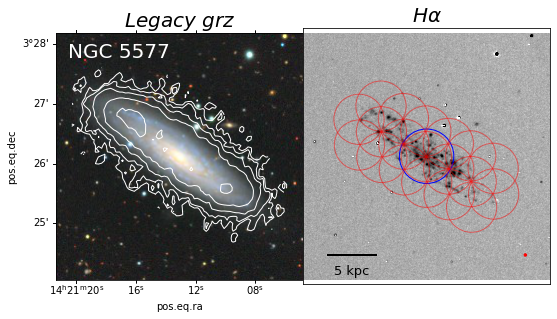

In [119]:
cutouts = os.path.join(cutoutpath,'VFID6108-NGC5577','')
haname = 'VFID6108-NGC5577-v19p134'
# INT, pixel scale = .331
ha = os.path.join(cutouts,haname+'-Ha.fits')
r = os.path.join(cutouts,haname+'-R.fits')
cs = os.path.join(cutouts,haname+'-CS.fits')
legacy_r = os.path.join(cutouts,'legacy','VFID6108-legacy-499-r.fits')
legacy_jpg = os.path.join(cutouts,'legacy','VFID6108-legacy-499.jpg')
vid = np.arange(len(v.main))[v.main['VFID'] == 'VFID6108']
vr = v.main['vr'][vid]
gra = v.main['RA'][vid]
gdec = v.main['DEC'][vid]
ned = v.main['NEDname'][vid][0]
print(gra[0],gdec[0])
print('vr = ',vr)

HIfile = 'MeerKAT_ALMA_target_list/J1420_fin_lw05_pbcorr_2_snr.fits'
HImap = fits.open(HIfile)
ax1, ax = display_gal(legacy_jpg,legacy_r,cs,HImap=HImap[0],alma=True,cmap='gray_r',zoom=2.,pscale=.331,percentile2=99.9,gname=ned,ra=gra[0],dec=gdec[0])
add_scale(ax,vr)
vname = 'VFID6108'

# overlay HI contours on RBG image


plt.savefig(vname+'-rgb-ha.png')
plt.savefig(ned.replace(' ','')+'-rgb-ha.png')

In [9]:
# NGC 3504, 5348, 5560, 5577, 

# halpha not ready for 4314,
targets = ['VFID3096','VFID5872','VFID6035','VFID6108','VFID2911']

# VFID3096

vr =    vr  
------
1538.9
who's zoomin' who?
754 754
412 1096 412 1096
412 1096 412 1096
ycenter =  249 249.5
136 362 136 362
plotting alma centers
pixel scale = 9.201021748595e-05 deg/pix
beam diam in pixels = 153.3646098952639


/home/rfinn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/home/rfinn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.


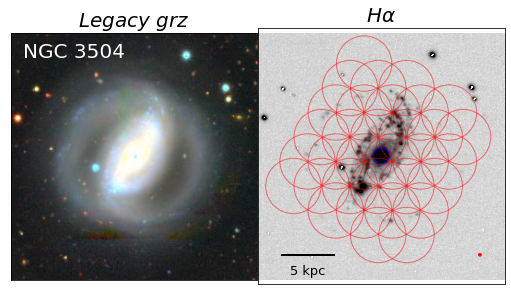

In [10]:
os.chdir(homedir+'/research/Virgo/alma/2022/')
cutouts = os.path.join(cutoutpath,'VFID3096-NGC3504','')
haname = 'VFID3096-NGC3504-v19p070'
#haname = 'VFID3096-NGC3504-2020-02-26-HDI-p012'
# INT, pixel scale = .331
ha = os.path.join(cutouts,haname+'-Ha.fits')
r = os.path.join(cutouts,haname+'-R.fits')
cs = os.path.join(cutouts,haname+'-CS.fits')
legacy_r = os.path.join(cutouts,'legacy','VFID3096-legacy-499-r.fits')
legacy_jpg = os.path.join(cutouts,'legacy','VFID3096-legacy-499.jpg')
vid = np.arange(len(v.main))[v.main['VFID'] == 'VFID3096']
vr = v.main['vr'][v.main['VFID'] == 'VFID3096']
ned = v.main['NEDname'][vid][0]
print('vr = ',vr)
ax1, ax = display_gal(legacy_jpg,legacy_r,cs,alma=True,cmap='gray_r',zoom=2.2,pscale=.331,percentile2=99.6,gname=ned)
add_scale(ax,vr)
vname = 'VFID3096'
plt.savefig(vname+'-rgb-ha.png')
plt.savefig(ned.replace(' ','')+'-rgb-ha.png')

# VFID5872

208.5469185 5.227286
vr =    vr  
------
1450.3
who's zoomin' who?
755 755
378 1132 378 1132
378 1132 378 1132
ycenter =  219 249.5
126 374 95 343
plotting alma centers
pixel scale = 9.200665954268e-05 deg/pix
beam diam in pixels = 153.37054058098104


/home/rfinn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/home/rfinn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.


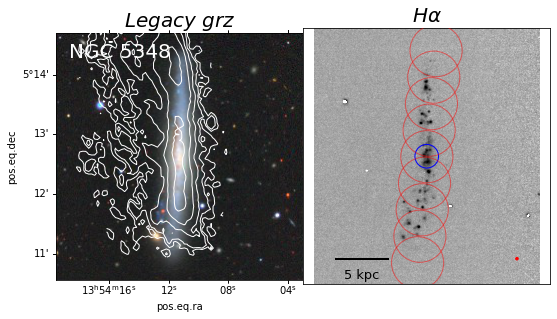

In [130]:
# something weird here

cutouts = os.path.join(cutoutpath,'VFID5872-NGC5348','')
haname = 'VFID5872-NGC5348-v19p120'
# INT, pixel scale = .331
ha = os.path.join(cutouts,haname+'-Ha.fits')
r = os.path.join(cutouts,haname+'-R.fits')
cs = os.path.join(cutouts,haname+'-CS.fits')
legacy_r = os.path.join(cutouts,'legacy','VFID5872-legacy-499-r.fits')
legacy_jpg = os.path.join(cutouts,'legacy','VFID5872-legacy-499.jpg')
vid = np.arange(len(v.main))[v.main['VFID'] == 'VFID5872']
vr = v.main['vr'][vid]
gra = v.main['RA'][vid]
gdec = v.main['DEC'][vid]
ned = v.main['NEDname'][vid][0]
print(gra[0],gdec[0])
print('vr = ',vr)

HIfile = 'MeerKAT_ALMA_target_list/J1355_fin_lw05_bpcorr_6_snr.fits'
HImap = fits.open(HIfile)
#HImap[0].data = np.fliplr(HImap[0].data)
ax1, ax = display_gal(legacy_jpg,legacy_r,cs,HImap=HImap[0],zoom=2.,alma=True,cmap='gray_r',pscale=.331,percentile2=99.97,gname=ned,ra=gra[0],dec=gdec[0])
add_scale(ax,vr)
vname = 'VFID5872'
plt.savefig(vname+'-rgb-ha.png')
plt.savefig(ned.replace(' ','')+'-rgb-ha.png')

# VFID6035

215.018397 3.992753
vr =    vr  
------
1730.2
who's zoomin' who?
755 755
378 1132 378 1132
378 1132 378 1132
ycenter =  248 249.5
126 374 124 372


/home/rfinn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:161: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/home/rfinn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.


plotting alma centers
pixel scale = 9.201090142597e-05 deg/pix
beam diam in pixels = 153.36346989779912


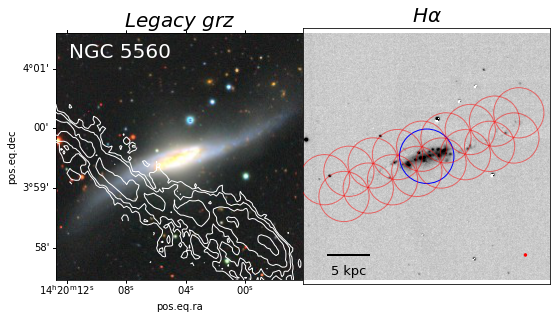

In [138]:
cutouts = os.path.join(cutoutpath,'VFID6035-NGC5560','')
haname = 'VFID6035-NGC5560-v19p131'
# INT, pixel scale = .331
ha = os.path.join(cutouts,haname+'-Ha.fits')
r = os.path.join(cutouts,haname+'-R.fits')
cs = os.path.join(cutouts,haname+'-CS.fits')
legacy_r = os.path.join(cutouts,'legacy','VFID6035-legacy-499-r.fits')
legacy_jpg = os.path.join(cutouts,'legacy','VFID6035-legacy-499.jpg')
vid = np.arange(len(v.main))[v.main['VFID'] == 'VFID6035']
vr = v.main['vr'][vid]
gra = v.main['RA'][vid]
gdec = v.main['DEC'][vid]
ned = v.main['NEDname'][vid][0]
print(gra[0],gdec[0])
print('vr = ',vr)

HIfile = 'MeerKAT_ALMA_target_list/J1420_fin_lw05_pbcorr_4_snr.fits'
HImap = fits.open(HIfile)
#HImap[0].data = np.fliplr(HImap[0].data)
                      
ax1, ax = display_gal(legacy_jpg,legacy_r,cs,HImap=HImap[0],alma=True,zoom=2.,cmap='gray_r',pscale=.331,percentile2=99.9,gname=ned,ra=gra[0],dec=gdec[0])
add_scale(ax,vr)
vname = 'VFID6035'
plt.savefig(vname+'-rgb-ha.png')
plt.savefig(ned.replace(' ','')+'-rgb-ha.png')

# VFID 6108

215.30457149999998 3.4358432
vr =    vr  
------
1489.1
who's zoomin' who?
755 755
465 1045 465 1045
465 1045 465 1045
ycenter =  248 249.5
155 345 153 343
plotting alma centers
pixel scale = 9.200673957821e-05 deg/pix
beam diam in pixels = 153.37040716583607


/home/rfinn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/home/rfinn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.


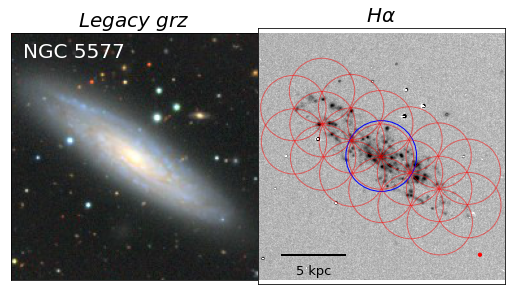

In [13]:
cutouts = os.path.join(cutoutpath,'VFID6108-NGC5577','')
haname = 'VFID6108-NGC5577-v19p134'
# INT, pixel scale = .331
ha = os.path.join(cutouts,haname+'-Ha.fits')
r = os.path.join(cutouts,haname+'-R.fits')
cs = os.path.join(cutouts,haname+'-CS.fits')
legacy_r = os.path.join(cutouts,'legacy','VFID6108-legacy-499-r.fits')
legacy_jpg = os.path.join(cutouts,'legacy','VFID6108-legacy-499.jpg')
vid = np.arange(len(v.main))[v.main['VFID'] == 'VFID6108']
vr = v.main['vr'][vid]
gra = v.main['RA'][vid]
gdec = v.main['DEC'][vid]
ned = v.main['NEDname'][vid][0]
print(gra[0],gdec[0])
print('vr = ',vr)
ax1, ax = display_gal(legacy_jpg,legacy_r,cs,alma=True,cmap='gray_r',zoom=2.6,pscale=.331,percentile2=99.9,gname=ned,ra=gra[0],dec=gdec[0])
add_scale(ax,vr)
vname = 'VFID6108'
plt.savefig(vname+'-rgb-ha.png')
plt.savefig(ned.replace(' ','')+'-rgb-ha.png')

In [14]:
os.getcwd()

'/home/rfinn/research/Virgo/alma/2022'

# VFID2911

In [15]:
# register CS halpa with legacy r image

from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp


In [16]:
cutouts = '/home/rfinn/temp/alma/'
haname = 'anbV2911'
# INT, pixel scale = .331
ha = os.path.join(cutouts,haname+'-Ha.fits')
r = os.path.join(cutouts,haname+'-R.fits')
cs = os.path.join(cutouts,haname+'-CS.fits')
legacy_r = os.path.join(cutouts,'legacy','VFID2911-legacy-940-r.fits')
legacy_jpg = os.path.join(cutouts,'legacy','VFID2911-legacy-940.jpg')
vid = np.arange(len(v.main))[v.main['VFID'] == 'VFID2911']
vr = v.main['vr'][vid]
gra = v.main['RA'][vid]
gdec = v.main['DEC'][vid]
ned = v.main['NEDname'][vid][0]
print(gra[0],gdec[0])
print('vr = ',vr)

185.63331 29.8954364
vr =    vr 
-----
981.7


In [17]:
hdu_r = fits.open(legacy_r)[0]
hdu_ha = fits.open(cs)[0]

# Targets 2023

| object | halpha | RA | DEC |
|-----|-----|-----|----|
|NGC5248     | |204.38341666666668 |8.885166666666667|
|NGC5348     ||208.54695833333332 |5.227444444444445|
|NGC5356     ||208.74358333333333 |5.333722222222222|
|NGC5470     ||211.63295833333333 |6.029694444444444|
|NGC5560     ||215.01870833333334 |3.992472222222222|
|NGC5566     ||215.08287500000003 |3.9337500000000003|
|NGC5577     ||215.304625 |3.435777777777778|
|NGC5806     ||225.00166666666667 |1.8913055555555556|
|CGCG021-013 ||227.024375 |1.6515277777777777|
|UGC9661     ||225.514625 |1.841277777777778|


In [40]:
names = ['NGC5248','NGC5348','NGC5356','NGC5470','NGC5560',\
         'NGC5566','NGC5577','NGC5806','CGCG 021-013', 'UGC9661']


In [43]:
for n in names:
    print(n)
    if np.sum(v.main['objname'] == n) > 0:
        print(v.main['VFID'][v.main['objname'] == n])
        
    else:
        if n == 'UGC9661':
            nn = 'UGC09661'
            if np.sum(v.main['objname'] == nn) > 0:
                #print(np.arange(len(v.main))[v.main['objname'] == nn])
                print(v.main['VFID'][v.main['objname'] == nn])
            else:
                print("still no match!!!")
        else:
            if np.sum(v.main['NEDname'] == n) > 0:
                #print(np.arange(len(v.main))[v.main['objname'] == nn])
                print(v.main['VFID'][v.main['NEDname'] == n])
            else:
                print("still no match!!!")
            
    print()
    print()

NGC5248
  VFID  
--------
VFID5308


NGC5348
  VFID  
--------
VFID5872


NGC5356
  VFID  
--------
VFID5859


NGC5470
  VFID  
--------
VFID5726


NGC5560
  VFID  
--------
VFID6035


NGC5566
  VFID  
--------
VFID6050


NGC5577
  VFID  
--------
VFID6108


NGC5806
  VFID  
--------
VFID6369


CGCG 021-013
  VFID  
--------
VFID6420


UGC9661
  VFID  
--------
VFID6379




In [46]:
hapath = {'NGC5248':'/home/rfinn/research/virgo-cutouts/all-cutouts-20210309/VFID5308-NGC5248',\
          'NGC5356':'/home/rfinn/research/virgo-cutouts/all-cutouts-20210309/VFID5859-NGC5356-2018-03-13-HDI-p056',\
          'NGC5470':,'/media/rfinn/hdata/cutouts/VFID5709-NGC5470-2017-05-20-WFC-VFID5726/'\
          'NGC5560':'/home/rfinn/research/virgo-cutouts/all-cutouts-20210309/VFID6035-NGC5560',\
          'NGC5566':'/home/rfinn/research/virgo-cutouts/all-cutouts-20210309/VFID6035-NGC5566',\
          'NGC5577':'/home/rfinn/research/virgo-cutouts/all-cutouts-20210309/VFID6108-NGC5577',\
          #'NGC5806':,\
          'CGCG 021-013':'/home/rfinn/research/virgo-cutouts/all-cutouts-20210309/VFID6420-CGCG021-013', \
          #'UGC9661'
         }